<a href="https://colab.research.google.com/github/zanzivyr/Tactile-Sensor/blob/main/YOLOv5_Deformations_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tactile Sensor: YOLOv5 Object Detection

## Summary

I aim to detect deformations on an artificial “finger” using a camera then visualize an approximation of the depression virtually. The concept relies on a ML stack where information is passed from one layer to another, generating predictions of the state of the finger along the way. At the end, a geometric transformation of predicted force vectors on the finger will create level curves of the approximated deformation shape in R3. Each ML layer will be trained using various experimental techniques. Due to transfer learning I will not be required to collect a large amount of data, instead I will be able to “tune” existing datasets to predict the required values.

In this first step, I fine-tune YOLOv5 to detect deformations in the TPU finger.

## Installation and Setup

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -U -r yolov5/requirements.txt  # install dependencies

%cd /content/yolov5

In [ ]:
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from IPython.display import Image  # for displaying images
#from utils.google_utils import gdrive_download  # for downloading models/datasets

print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

torch 1.13.1+cu117 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


## Training

### Dataset imported from Roboflow

This custom dataset was created by 3D printing a TPU finger (with PLA sleeve) then placing an iPhone 14 underneath and recording video. Afterwards the stills from the video were taken and annotated with https://www.makesense.ai/. The dataset was exported in YOLOv5 format then uploaded to https://app.roboflow.com/tactile-sensor/deformations/2.

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("tactile-sensor").project("deformations")
dataset = project.version(2).download("yolov5")

### Fine-tune YOLOv5s

- 16 batches
- 120 epochs

The model gets rises to 96.1% mAP (mean Average Precision) by epoch 44, but then drops quickly to 69.4% by epoch 48. Several oscilations happen before settling at an mAP of 99.5% at epoch 107. I am unsure if this represents overfitting.

mean Average Precision - https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173 

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 640 --batch 16 --epochs 120 --data {dataset.location}/data.yaml --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name yolov5s_results  --cache

/content/yolov5
train: weights=yolov5s.pt, cfg=./models/yolov5s.yaml, data=/content/yolov5/Deformations-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=120, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-55-g632bf48 Python-3.8.16 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.

### Results from Roboflow

In this image you can see that training on Roboflow also yield similar results.

https://app.roboflow.com/tactile-sensor/deformations/2/train/results 

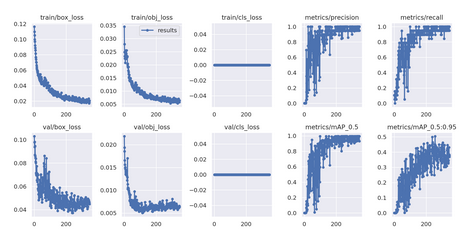

## Ground Truth Training Data

These are the images from the Roboflow dataset. Synthetic annotated images were added to the dataset by rotating the base set.

GROUND TRUTH TRAINING DATA:


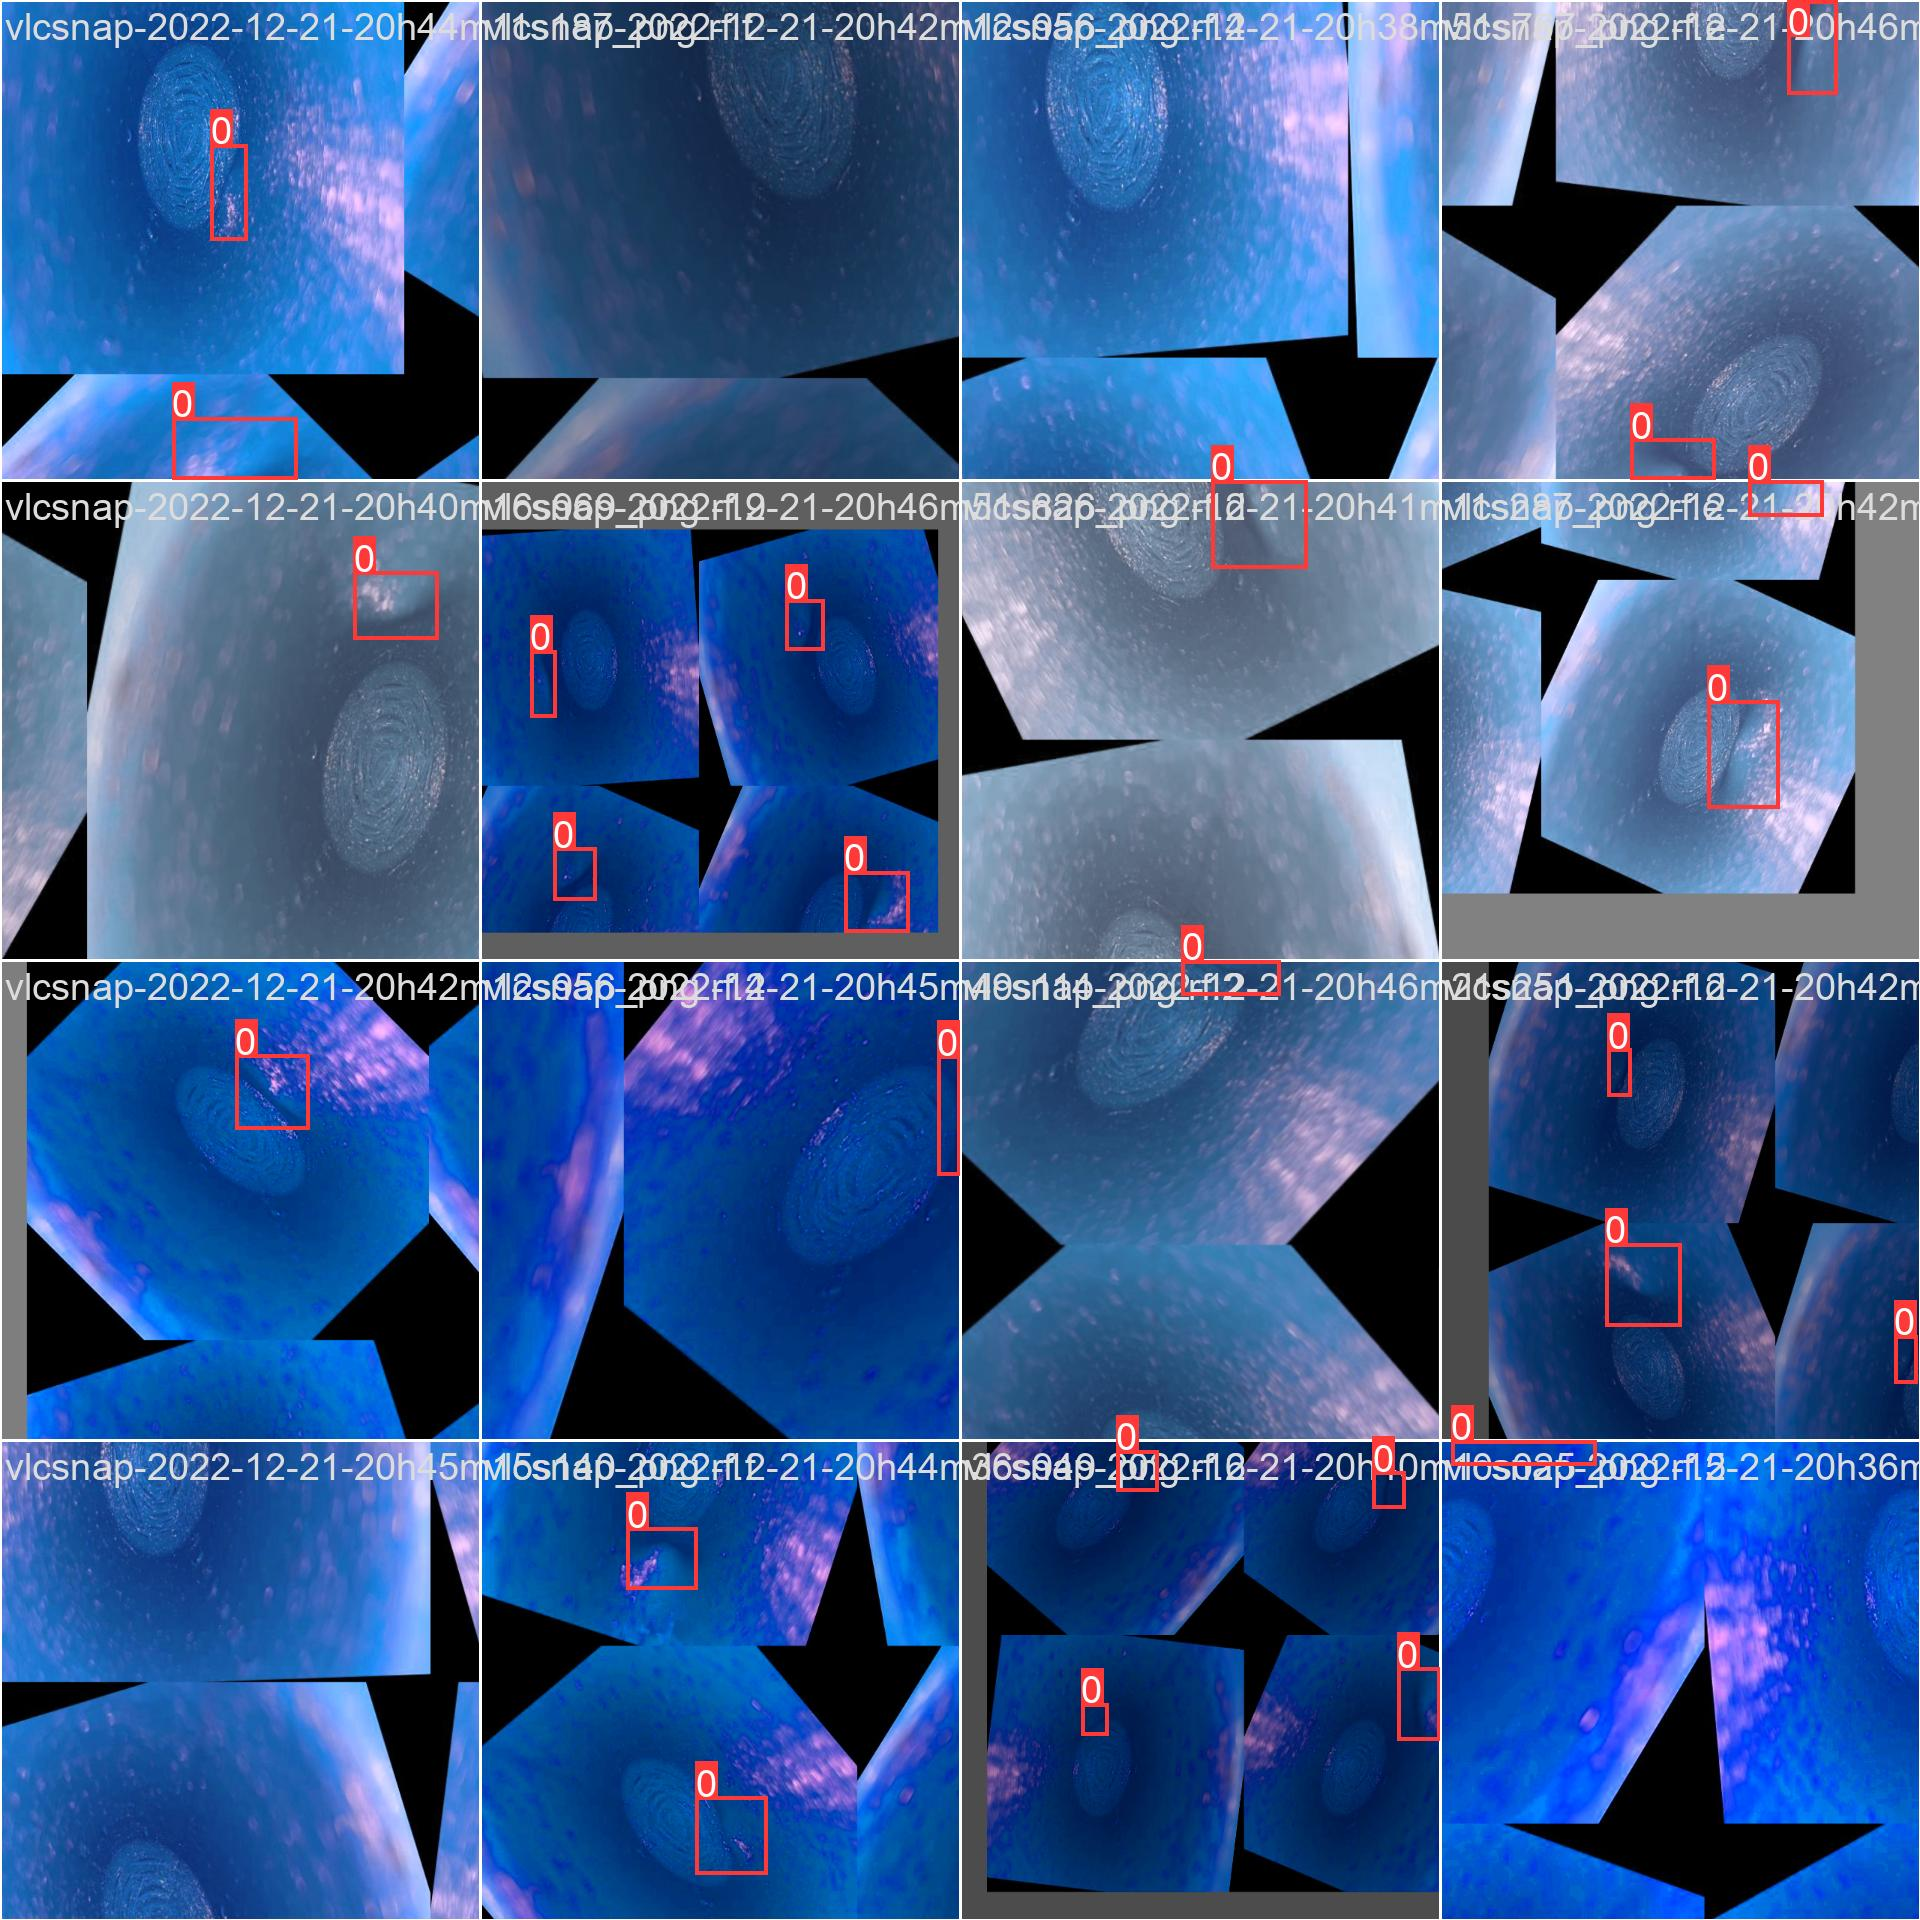

In [ ]:
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results7/train_batch0.jpg', width=900)

### Annotation Heatmap

Heatmap from Roboflow: https://app.roboflow.com/tactile-sensor/deformations/health

As you can see from this annotation heatmap, the spread of the sample data covers most of the inside of the finger. However, there is on blind spot in the bottom where there is a gap between the ring of green areas.

This proves to be a problem when running the model for inferences.

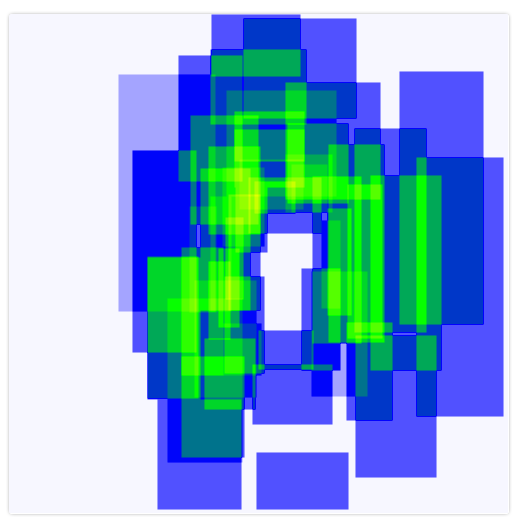

## Inference

In [ ]:
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results7/weights/last.pt --img 640 --conf 0.4 --source /content/yolov5/Deformations-2/test/images/

detect: weights=['/content/yolov5/runs/train/yolov5s_results7/weights/last.pt'], source=/content/yolov5/Deformations-2/test/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-55-g632bf48 Python-3.8.16 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/6 /content/yolov5/Deformations-2/test/images/vlcsnap-2022-12-21-20h39m44s166_png.rf.4471edcd4fd59738fa80fc3fce68dfef.jpg: 640x640 1 0, 12.6ms
image 2/6 /content/yolov5/Deformations-2/test/images/vlcsnap-2022-12-21-20h39m48s906_png.rf.75c2e63655ab9155bd1545c7f66cc430.jpg: 640x640 1 0, 

## Display

We can see that the model has been successfully fine-tuned to detect deformations in the TPU finger. The images below are inferences on the test dataset (200 training, 19 validation, 6 test).

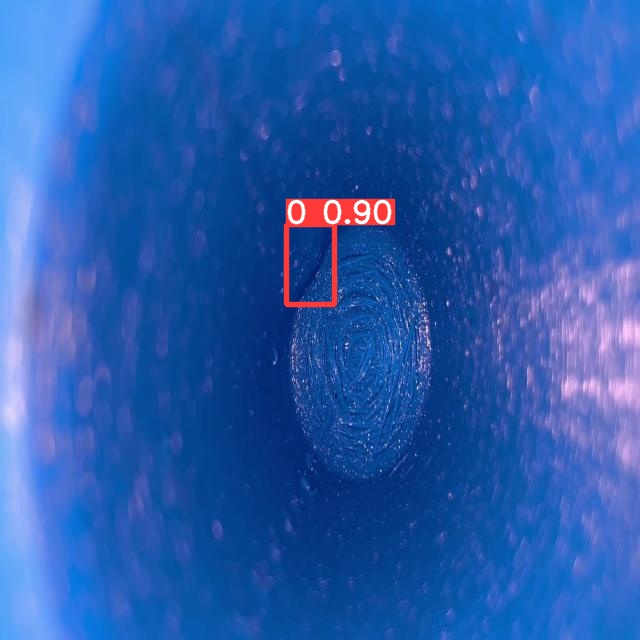

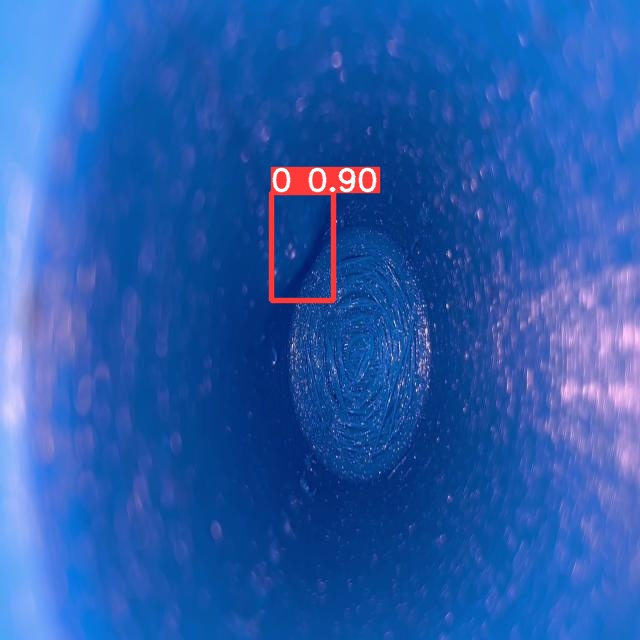

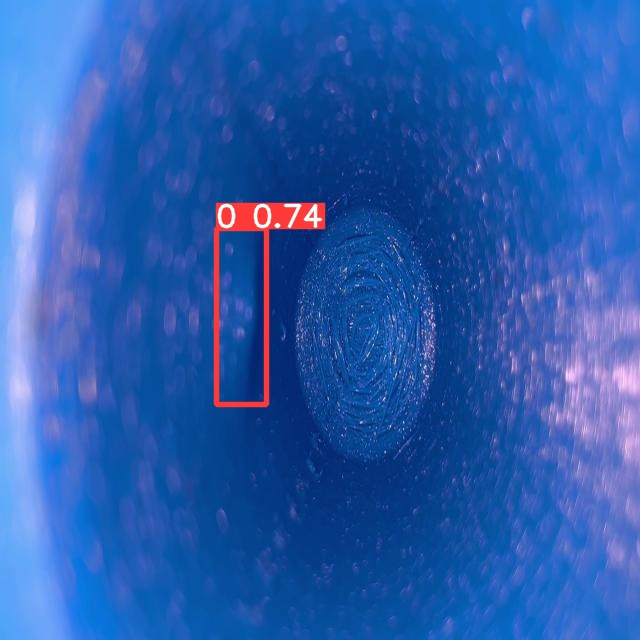

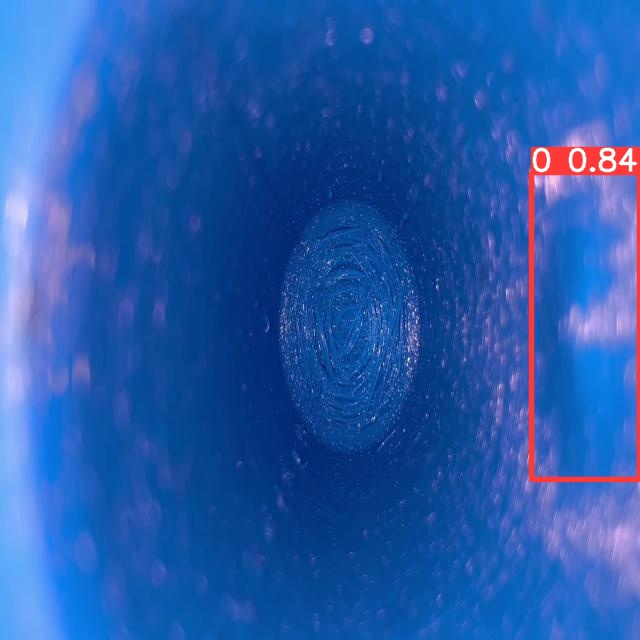

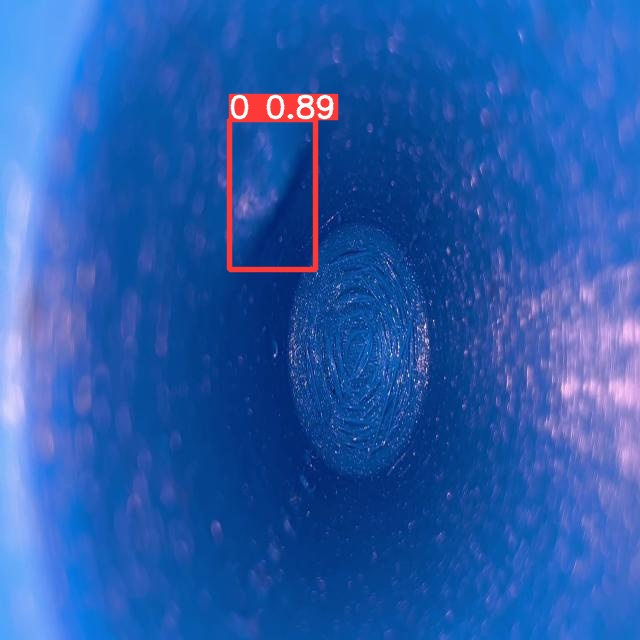

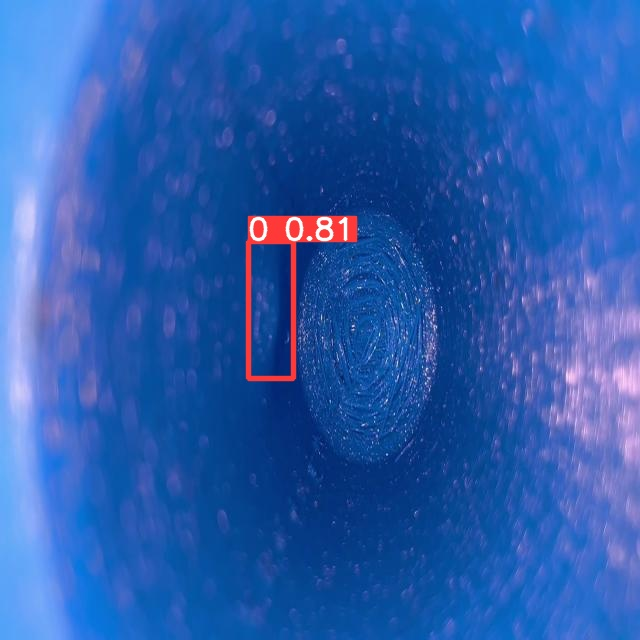

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp4/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# Next Steps

From here data will flow into the CNN to obtain further predicitions on deformations in the TPU finger.